# Run Opportunities Created-  A new baseball statistic
***
This is a Sabermetrics final project by Meredith Burgess

# What is Run Opportunities created? 

There are many baseball statistics that attempt to measure the number of runs a player contributes toward their team. Gaining runs, after all, is the objective of the game and how the winner is determined. Understanding a players contribution to their score is equivalent of their worth to the team. Stats like runs created try to measure this exactly, while other stats try to measure players abilities to do things that will later turn into runs, such as getting on base. 

Run opportunities created is a statistic that aims to look at indirect contribution toward overall runs. Rather than looking whether or not a player directly helps create a run in their offensive play (namely, being up to bat on the plate), ROC looks into the ability of a batter to set up a situation which will later create a run. This works under the assumption that there is a "long game" strategy to baseball. Here we look at sliding windows of events from retrosheet data (ranging from 2010 to 2013). Windows consist of sizes of 2, 3, and 4 events at a time. We say that order matters in these windows. A single in the first event of the window is not the same as a single in the second, etc. 

In these windows, or N-grams of baseball events, we are looking for windows that end in a run scored. After these windows are collected, we keep count of all events that happened and the subsequent probabilities of transitioning between them. We also look at the players involved in the event and attribute a score to them based on the probability of that event leading to the next one. These scores are accumulated and then divided by total plate appearances (regardless of whether or not that PA occured in a run scoring window or not). 

In the rest of this notebook, we will look at data collected and calculated. 

In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display, HTML
%matplotlib inline

In [31]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [35]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as tk
import operator
#import ipywidgets as widgets
#from ipywidgets import interact, interactive, fixed, interact_manual
#from IPython.display import display
%matplotlib inline

In [8]:
#lists and dictionaries 
listOfEvents = ["Out", "K", "SB", "DI", "CS", "PK", "WP", "PB", "BK", "OA", "FE", "NIBB", "IBB", "HBP", "XI",
"ROE", "FC", "1B", "2B", "3B", "HR" ]
listOfEventsLong = ["Generic Out", "Strikeout", "Stolen Base", "Defensive Indifference", "Caught Stealing", "Pickoff", "Wild Pitch", "Passed Ball",
"Balk", "Other Advance", "Foul Error", "Nonintentional Walk", "Intentional Walk", "Hit By Pitch", "Interference", "Error", "Fielder Choice",
"Single", "Double", "Triple", "Homerun"]
eventCodes = [2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
eventCodesDict = {"Out":2, "K":3, "SB":4, "DI":5, "CS":6, "PK":8, "WP":9, "PB":10, "BK":11, "OA":12, 
"FE":13, "NIBB":14, "IBB":15, "HBP":16, "XI":17,"ROE":18, "FC":19, "1B":20, "2B":21, "3B":22, "HR":23}
eventCodesDictReversedFull = {2:["Out","Out"], 3:["K", "Strikeout"], 4:["SB", "Stolen Base"], 5:["DI", "Defensive Indifference"],
6:["CS", "Caught Stealing"], 8:["PK", "Pickoff"], 9:["WP", "Wild Pitch"], 10:["PB", "Passed Ball"], 11:["BK", "Balk"], 12:["OA", "Other Advance"], 
13:["FE", "Foul Error"], 14:["NIBB", "Nonintentional Walk"], 15:["IBB", "Intentional Walk"], 16:["HBP", "Hit by pitch"], 
17:["XI", "Interference"],18:["ROE", "Error"], 19:["FC", "Fielder Choice"], 20:["1B", "Single"], 21:["2B", "Double"],
22:["3B", "Triple"], 23:["HR", "Homerun"]}

#load files 
events2DF = pd.read_csv('2gramofevents.csv')
events3DF = pd.read_csv('3gramofevents.csv')
events4DF = pd.read_csv('4gramofevents.csv')

#set lengths 
total2 = len(events2DF)
total3 = len(events3DF)
total4 = len(events4DF)


# Event frequencies
***
Here we look at event frequences of each event in each slot of a window (2, 3, or 4).
Each histogram shows the frequency of each event. 


In [11]:
eventFreq2 = {}
eventFreq3 = {}
eventFreq4 = {}

eventFreq2_1 = {}
eventFreq2_2 = {}

eventFreq3_1 = {}
eventFreq3_2 = {}
eventFreq3_3 = {}

eventFreq4_1 = {}
eventFreq4_2 = {}
eventFreq4_3 = {}
eventFreq4_4 = {}

for v in eventCodes:
    eventFreq2[v] = 0
    eventFreq3[v] = 0
    eventFreq4[v] = 0
    
    eventFreq2_1[v] = 0
    eventFreq2_2[v] = 0
    eventFreq3_1[v] = 0
    eventFreq3_2[v] = 0
    eventFreq3_3[v] = 0
    eventFreq4_1[v] = 0
    eventFreq4_2[v] = 0
    eventFreq4_3[v] = 0
    eventFreq4_4[v] = 0

for v in range(0, total2):
    eventFreq2[events2DF['event_cd'][v]] += 1
    eventFreq2[events2DF['eventCD2'][v]] += 1
    
    eventFreq2_1[events2DF['event_cd'][v]] += 1
    eventFreq2_2[events2DF['eventCD2'][v]] += 1
    
for v in range(0, total3):
    eventFreq3[events3DF['event_cd'][v]] += 1
    eventFreq3[events3DF['eventCD2'][v]] += 1
    eventFreq3[events3DF['eventCD3'][v]] += 1
    
    eventFreq3_1[events3DF['event_cd'][v]] += 1
    eventFreq3_2[events3DF['eventCD2'][v]] += 1
    eventFreq3_3[events3DF['eventCD3'][v]] += 1
    
for v in range(0, total4):
    eventFreq4[events4DF['event_cd'][v]] += 1
    eventFreq4[events4DF['eventCD2'][v]] += 1
    eventFreq4[events4DF['eventCD3'][v]] += 1
    eventFreq4[events4DF['eventCD4'][v]] += 1
    
    eventFreq4_1[events4DF['event_cd'][v]] += 1
    eventFreq4_2[events4DF['eventCD2'][v]] += 1
    eventFreq4_3[events4DF['eventCD3'][v]] += 1
    eventFreq4_4[events4DF['eventCD4'][v]] += 1
    
eventNameFreq2 = {}
eventNameFreq3 = {}
eventNameFreq4 = {}

eventNameFreq2_1 = {}
eventNameFreq2_2 = {}

eventNameFreq3_1 = {}
eventNameFreq3_2 = {}
eventNameFreq3_3 = {}

eventNameFreq4_1 = {}
eventNameFreq4_2 = {}
eventNameFreq4_3 = {}
eventNameFreq4_4 = {}

for n in listOfEvents:
    k = eventCodesDict[n]
    eventNameFreq2[n] = float(eventFreq2[k]) / float(total2*2)
    eventNameFreq3[n] = float(eventFreq3[k]) / float(total3*3)
    eventNameFreq4[n] = float(eventFreq4[k]) / float(total4*4)
    
    eventNameFreq2_1[n] = float(eventFreq2_1[k]) / float(total2)
    eventNameFreq2_2[n] = float(eventFreq2_2[k]) / float(total2)

    eventNameFreq3_1[n] = float(eventFreq3_1[k]) / float(total3)
    eventNameFreq3_2[n] = float(eventFreq3_2[k]) / float(total3)
    eventNameFreq3_3[n] = float(eventFreq3_3[k]) / float(total3)

    eventNameFreq4_1[n] = float(eventFreq4_1[k]) / float(total4)
    eventNameFreq4_2[n] = float(eventFreq4_2[k]) / float(total4)
    eventNameFreq4_3[n] = float(eventFreq4_3[k]) / float(total4)
    eventNameFreq4_4[n] = float(eventFreq4_4[k]) / float(total4)

First, we can see the overall frequencies of events in each n-gram of events, regardless of placement in the sequence. 

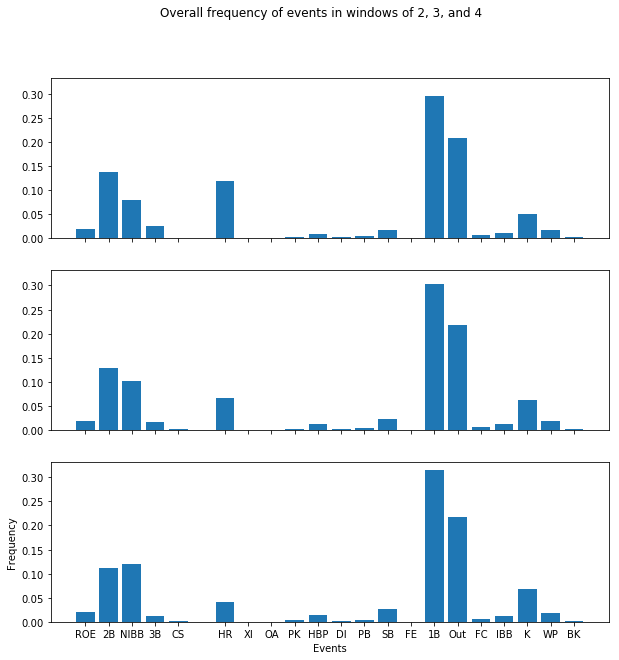

In [46]:
fig, ax = plt.subplots(3, 1, figsize=(10,10), sharey=True, sharex=True)
ax[0].bar(list(eventFreq2.keys()), list(eventNameFreq2.values()), align='center')
ax[1].bar(list(eventFreq3.keys()), list(eventNameFreq3.values()), align='center')
ax[2].bar(list(eventFreq4.keys()), list(eventNameFreq4.values()), align='center')

plt.xticks(list(eventFreq2.keys()), list(eventNameFreq2.keys()))
plt.xlabel("Events")
plt.ylabel("Frequency")
fig.suptitle("Overall frequency of events in windows of 2, 3, and 4")
plt.show()

Next, we can look at the order specific frequencies. By this, we mean looking at the counts of, say, a 1B in either the first, second, third, or fourth slot of a window of events. We do this because in a certain sense, order matters. 

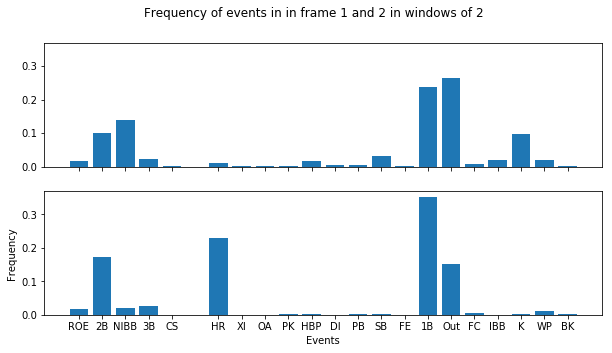

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(10,5), sharey=True, sharex=True)
ax[0].bar(list(eventFreq2_1.keys()), list(eventNameFreq2_1.values()), align='center')
ax[1].bar(list(eventFreq2_2.keys()), list(eventNameFreq2_2.values()), align='center')

plt.xticks(list(eventFreq2_1.keys()), list(eventNameFreq2_1.keys()))
plt.xlabel("Events")
plt.ylabel("Frequency")
fig.suptitle("Frequency of events in in frame 1 and 2 in windows of 2")
plt.show()

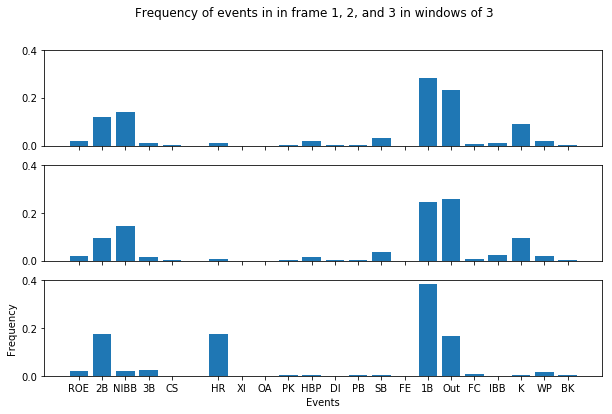

In [48]:
fig, ax = plt.subplots(3, 1, figsize=(10,6), sharey=True, sharex=True)
ax[0].bar(list(eventFreq3_1.keys()), list(eventNameFreq3_1.values()), align='center')
ax[1].bar(list(eventFreq3_2.keys()), list(eventNameFreq3_2.values()), align='center')
ax[2].bar(list(eventFreq3_3.keys()), list(eventNameFreq3_3.values()), align='center')

plt.xticks(list(eventFreq3_1.keys()), list(eventNameFreq3_1.keys()))
plt.xlabel("Events")
plt.ylabel("Frequency")
fig.suptitle("Frequency of events in in frame 1, 2, and 3 in windows of 3")
plt.show()

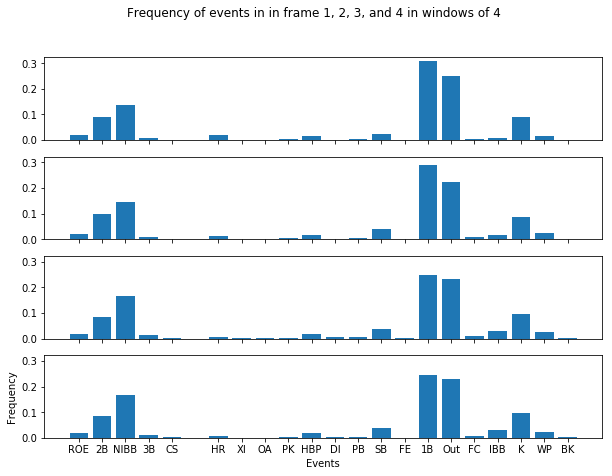

In [49]:
fig, ax = plt.subplots(4, 1, figsize=(10,7), sharey=True, sharex=True)
ax[0].bar(list(eventFreq4_1.keys()), list(eventNameFreq4_1.values()), align='center')
ax[1].bar(list(eventFreq4_2.keys()), list(eventNameFreq4_2.values()), align='center')
ax[2].bar(list(eventFreq4_3.keys()), list(eventNameFreq4_3.values()), align='center')
ax[3].bar(list(eventFreq4_3.keys()), list(eventNameFreq4_3.values()), align='center')

plt.xticks(list(eventFreq4_1.keys()), list(eventNameFreq4_1.keys()))
plt.xlabel("Events")
plt.ylabel("Frequency")
fig.suptitle("Frequency of events in in frame 1, 2, 3, and 4 in windows of 4")
plt.show()

# Transition Matrices
***
We can also look at transitions between events and the probability of one event transitioning to another. The colored grids show each event and the likelihood of transitioning to another. More yellow colors indicate a higher probability of transition, while darker blue colors indicate a lower likelihood. 


In [16]:
#transition matrices 

trans2_1to2 = {}

trans3_1to2 = {}
trans3_2to3 = {}

trans4_1to2 = {}
trans4_2to3 = {}
trans4_3to4 = {}

#for counting of unique sequences
hashable2Seqs = {}
hashable3Seqs = {}
hashable4Seqs = {}

for i in range(2, 24):
    trans2_1to2[i] = {}

    trans3_1to2[i] = {}
    trans3_2to3[i] = {}

    trans4_1to2[i] = {}
    trans4_2to3[i] = {}
    trans4_3to4[i] = {}

#count transitions
for v in range(0, total2):
    e1 = events2DF['event_cd'][v]
    e2 = events2DF['eventCD2'][v]
    trans2_1to2[e1][e2] = trans2_1to2[e1].get(e2, 0) + 1
    hashable2Seqs[str(e1) + "_" + str(e2)] = hashable2Seqs.get(str(e1) + "_" + str(e2), 0) + 1
    
for v in range(0, total3):
    e1 = events3DF['event_cd'][v]
    e2 = events3DF['eventCD2'][v]
    e3 = events3DF['eventCD3'][v]
    trans3_1to2[e1][e2] = trans3_1to2[e1].get(e2, 0) + 1
    trans3_2to3[e2][e3] = trans3_2to3[e2].get(e3, 0) + 1
    hashable3Seqs[str(e1) + "_" + str(e2) + "_" + str(e3)] = hashable3Seqs.get(str(e1) + "_" + str(e2) + "_" + str(e3), 0) + 1
    
for v in range(0, total4):
    e1 = events4DF['event_cd'][v]
    e2 = events4DF['eventCD2'][v]
    e3 = events4DF['eventCD3'][v]
    e4 = events4DF['eventCD4'][v]
    trans4_1to2[e1][e2] = trans4_1to2[e1].get(e2, 0) + 1
    trans4_2to3[e2][e3] = trans4_2to3[e2].get(e3, 0) + 1
    trans4_3to4[e3][e4] = trans4_3to4[e3].get(e4, 0) + 1
    hashable4Seqs[str(e1) + "_" + str(e2) + "_" + str(e3) +"_" + str(e4)] = hashable4Seqs.get(str(e1) + "_" + str(e2) + "_" + str(e3) + "_" + str(e4), 0) + 1

    
#normalize 
for k in range(2, 24):
    total = 0
    for k2 in trans2_1to2[k].keys():
        total += trans2_1to2[k][k2]
    for k2 in trans2_1to2[k].keys():
        trans2_1to2[k][k2] = round(float(trans2_1to2[k][k2])/ float(total), 5)
        
    total = 0
    for k2 in trans3_1to2[k].keys():
        total += trans3_1to2[k][k2]
    for k2 in trans3_1to2[k].keys():
        trans3_1to2[k][k2] = round(float(trans3_1to2[k][k2])/ float(total), 5)
    total = 0
    for k2 in trans3_2to3[k].keys():
        total += trans3_2to3[k][k2]
    for k2 in trans3_2to3[k].keys():
        trans3_2to3[k][k2] = round(float(trans3_2to3[k][k2])/ float(total), 5)
        
    total = 0
    for k2 in trans4_1to2[k].keys():
        total += trans4_1to2[k][k2]
    for k2 in trans4_1to2[k].keys():
        trans4_1to2[k][k2] = round(float(trans4_1to2[k][k2])/ float(total), 5)
    total = 0
    for k2 in trans4_2to3[k].keys():
        total += trans4_2to3[k][k2]
    for k2 in trans4_2to3[k].keys():
        trans4_2to3[k][k2] = round(float(trans4_2to3[k][k2])/ float(total), 5)
    total = 0
    for k2 in trans4_3to4[k].keys():
        total += trans4_3to4[k][k2]
    for k2 in trans4_3to4[k].keys():
        trans4_3to4[k][k2] = round(float(trans4_3to4[k][k2])/ float(total), 5)

Done


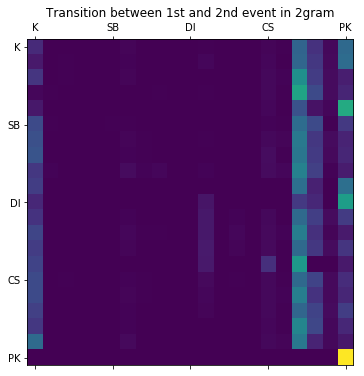

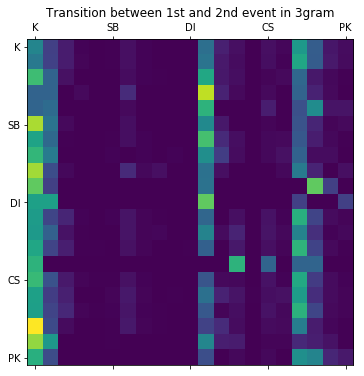

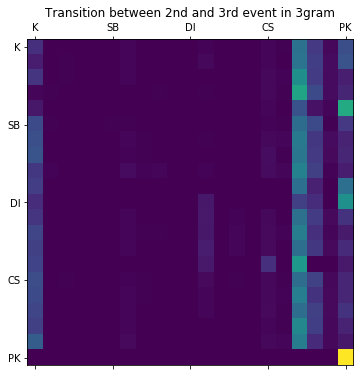

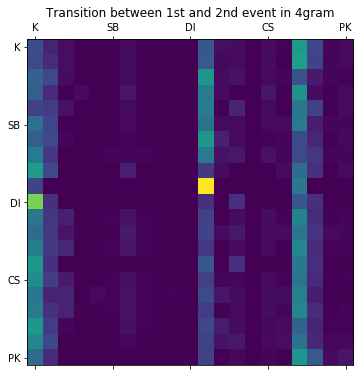

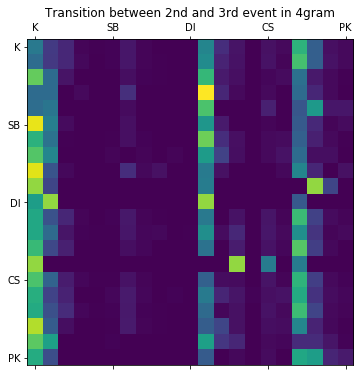

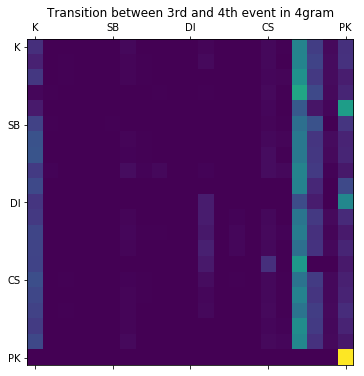

In [41]:
allMyTransMatrices = [trans2_1to2, trans3_1to2, trans3_2to3, trans4_1to2, trans4_2to3, trans4_3to4]
titles = ["Transition between 1st and 2nd event in 2gram","Transition between 1st and 2nd event in 3gram",
         "Transition between 2nd and 3rd event in 3gram", "Transition between 1st and 2nd event in 4gram",
         "Transition between 2nd and 3rd event in 4gram", "Transition between 3rd and 4th event in 4gram"]

titleCt=0 

for d in allMyTransMatrices:
    
    myMtx = np.zeros((len(eventCodes), len(eventCodes)))
    for i in range(0, len(eventCodes)):
        for j in range(0, len(eventCodes)):
            if eventCodes[i] in d.keys():
                if eventCodes[j] in d[eventCodes[i]].keys():
                    myMtx[i, j] = d[eventCodes[i]][eventCodes[j]]
                else:
                    myMtx[i, j] = 0
            else:
                myMtx[i, j] = 0

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.set_xticklabels(listOfEvents)
    ax.set_yticklabels(listOfEvents)
    ax.xaxis.set_major_locator(tk.MultipleLocator(1))
    ax.yaxis.set_major_locator(tk.MultipleLocator(1))
    
    #plt.xticks(range(len(listOfEvents)), listOfEvents)
    plt.title(titles[titleCt])
    
    ax.matshow(myMtx)
    plt.show()
    titleCt += 1

# Sequences
***
Now we look at sequence frequencies. What are the most recurring sequences?  

We start with the top 10 sequences of 2 events

In [106]:
#top sequences 

#newA = dict(sorted(A.iteritems(), key=operator.itemgetter(1), reverse=True)[:5])

topSeqsOf2 = dict(sorted(hashable2Seqs.items(), key=operator.itemgetter(1), reverse=True)[:10])
topSeqsOf3 = dict(sorted(hashable3Seqs.items(), key=operator.itemgetter(1), reverse=True)[:10])
topSeqsOf4 = dict(sorted(hashable4Seqs.items(), key=operator.itemgetter(1), reverse=True)[:10])

#print(topSeqsOf2, topSeqsOf3, topSeqsOf4)

for event in topSeqsOf2.keys(): 
    isoEvent = event.split("_")
    print(eventCodesDictReversedFull[int(isoEvent[0])][1], ",", eventCodesDictReversedFull[int(isoEvent[1])][1])
    print("Count", topSeqsOf2[event])
    print("Percentage", round(float(topSeqsOf2[event])/float(total2),5)*100, "% \n")


Nonintentional Walk , Single
Count 2954
Percentage 4.784 % 

Single , Single
Count 4847
Percentage 7.85 % 

Double , Single
Count 2825
Percentage 4.575 % 

Out , Homerun
Count 5584
Percentage 9.044 % 

Single , Out
Count 2803
Percentage 4.54 % 

Strikeout , Homerun
Count 2145
Percentage 3.474 % 

Out , Double
Count 2354
Percentage 3.8129999999999997 % 

Out , Single
Count 5297
Percentage 8.579 % 

Single , Double
Count 2965
Percentage 4.802 % 

Single , Homerun
Count 2646
Percentage 4.2860000000000005 % 



The top 10 sequences of 3 events

In [107]:
for event in topSeqsOf3.keys(): 
    isoEvent = event.split("_")
    print(eventCodesDictReversedFull[int(isoEvent[0])][1], ",", eventCodesDictReversedFull[int(isoEvent[1])][1], ",", eventCodesDictReversedFull[int(isoEvent[2])][1],)
    print("Count", topSeqsOf3[event])
    print("Percentage", round(float(topSeqsOf3[event])/float(total3),5)*100, "% \n")

Out , Single , Single
Count 874
Percentage 1.5859999999999999 % 

Single , Out , Double
Count 802
Percentage 1.455 % 

Nonintentional Walk , Single , Single
Count 848
Percentage 1.539 % 

Out , Out , Homerun
Count 1298
Percentage 2.355 % 

Out , Double , Single
Count 896
Percentage 1.6260000000000001 % 

Single , Out , Single
Count 1494
Percentage 2.711 % 

Double , Out , Single
Count 1160
Percentage 2.105 % 

Single , Single , Single
Count 1860
Percentage 3.375 % 

Out , Single , Double
Count 807
Percentage 1.464 % 

Single , Single , Out
Count 1012
Percentage 1.836 % 



The top 10 sequences of 4 events

In [108]:
for event in topSeqsOf4.keys(): 
    isoEvent = event.split("_")
    print(eventCodesDictReversedFull[int(isoEvent[0])][1], ",", eventCodesDictReversedFull[int(isoEvent[1])][1], ",", eventCodesDictReversedFull[int(isoEvent[2])][1], ",",  eventCodesDictReversedFull[int(isoEvent[3])][1])
    print("Count", topSeqsOf4[event])
    print("Percentage", round(float(topSeqsOf4[event])/float(total4),5)*100, "% \n")

Single , Single , Single , Single
Count 340
Percentage 0.787 % 

Single , Out , Single , Single
Count 404
Percentage 0.936 % 

Single , Single , Single , Out
Count 244
Percentage 0.565 % 

Single , Single , Out , Out
Count 289
Percentage 0.6689999999999999 % 

Single , Out , Out , Single
Count 352
Percentage 0.815 % 

Out , Single , Single , Single
Count 577
Percentage 1.336 % 

Out , Double , Out , Single
Count 256
Percentage 0.5930000000000001 % 

Out , Nonintentional Walk , Single , Single
Count 291
Percentage 0.674 % 

Single , Single , Out , Single
Count 559
Percentage 1.294 % 

Out , Single , Out , Single
Count 246
Percentage 0.5700000000000001 % 



# Looking at unique sequences 
***
We can look at sequences of our design here. Inputting each event will show the percentage frequency of that event in that order of the sequence, as well as the probability of transitioning between each one. Finally, we can see the probability of observing the sequence as a whole. 

In [126]:
inputSeqs = ['1B', 'K', 'HR']


n = len(inputSeqs)
inputSeqsCd = []
for s in inputSeqs:
    inputSeqsCd.append(eventCodesDict[s])

print("Frequencies of")
if n == 2: 
    print(str(inputSeqs[0]), ":", float(eventFreq2_1[inputSeqsCd[0]]) / float(total2))
    print(str(inputSeqs[1]), ":", float(eventFreq2_2[inputSeqsCd[1]]) / float(total2))
elif n == 3: 
    print(str(inputSeqs[0]), ":", float(eventFreq3_1[inputSeqsCd[0]]) / float(total3))
    print(str(inputSeqs[1]), ":", float(eventFreq3_2[inputSeqsCd[1]]) / float(total3))
    print(str(inputSeqs[2]), ":", float(eventFreq3_3[inputSeqsCd[2]]) / float(total3))
elif n == 4: 
    print(str(inputSeqs[0]), ":", float(eventFreq4_1[inputSeqsCd[0]]) / float(total4))
    print(str(inputSeqs[1]), ":", float(eventFreq4_2[inputSeqsCd[1]]) / float(total4))
    print(str(inputSeqs[2]), ":", float(eventFreq4_3[inputSeqsCd[2]]) / float(total4))
    print(str(inputSeqs[3]), ":", float(eventFreq4_4[inputSeqsCd[3]]) / float(total4))
print("\n")

print("Probability of transitioning from ")
if n == 2: 
    print(str(inputSeqs[0]), "to", str(inputSeqs[1]), ":", trans2_1to2[inputSeqsCd[0]][inputSeqsCd[1]])

    s = str(inputSeqsCd[0]) + "_" + str(inputSeqsCd[1]) 
    print("\n")
    print("Probability of seeing this sequence")
    print(round(float(hashable2Seqs[s])/float(total2),5), "%")
if n == 3: 
    print(str(inputSeqs[0]), "to", str(inputSeqs[1]), ":", trans3_1to2[inputSeqsCd[0]][inputSeqsCd[1]])
    print(str(inputSeqs[1]), "to", str(inputSeqs[2]), ":", trans3_2to3[inputSeqsCd[1]][inputSeqsCd[2]])

    s = str(inputSeqsCd[0]) + "_" + str(inputSeqsCd[1]) + "_" +str(inputSeqsCd[2]) 
    print("\n")
    print("Probability of seeing this sequence")
    print(round(float(hashable3Seqs[s])/float(total3),5), "%")
elif n == 4:
    print(str(inputSeqs[0]), "to", str(inputSeqs[1]), ":", trans4_1to2[inputSeqsCd[0]][inputSeqsCd[1]])
    print(str(inputSeqs[1]), "to", str(inputSeqs[2]), ":", trans4_2to3[inputSeqsCd[1]][inputSeqsCd[2]])
    print(str(inputSeqs[2]), "to", str(inputSeqs[3]), ":", trans4_3to4[inputSeqsCd[2]][inputSeqsCd[3]])

    s = str(inputSeqsCd[0]) + "_" + str(inputSeqsCd[1]) + "_" +str(inputSeqsCd[2] + "_" + str(inputSeqsCd[3])) 
    print("\n")
    print("Probability of seeing this sequence")
    print(round(float(hashable4Seqs[s])/float(total4),5) * 100, "%")

Frequencies of
1B : 0.28371856743713486
K : 0.09557676258209659
HR : 0.1761493522987046


Probability of transitioning from 
1B to K : 0.09061
K to HR : 0.25399


Probability of seeing this sequence
0.00459 %


# Top ROC Players

In [50]:
#player scores data 
statsDF = pd.read_csv('allStats.csv')

print("Highest ROC scores in 2 events")
print(statsDF.sort_values('2ROC', ascending=False).head(10))
print("\n")

print("Highest ROC scores in 3 events")
print(statsDF.sort_values('3ROC', ascending=False).head(10))
print("\n")

print("Highest ROC scores in 4 events")
print(statsDF.sort_values('4ROC', ascending=False).head(10))

playerNames = []
for line in range(0,len(statsDF)):
    name = str(statsDF['firstName'][line]) + " " + str(statsDF['lastName'][line])
    playerNames.append(name)
    
playerNames.sort()

Highest ROC scores in 2 events
     firstName   lastName   RC  OBP      2ROC      3ROC      4ROC
1377      Luis      Marte  0.0  0.0  0.340700  0.000000  0.000000
874       Nick    Vincent  0.0  0.0  0.329770  0.000000  0.449670
1485    Daniel       Bard  0.0  0.0  0.170350  0.000000  0.000000
494       Jose  Arredondo  0.0  0.5  0.164440  0.000000  0.192120
56       Dylan    Axelrod  0.0  0.5  0.164440  0.007815  0.328160
363     Dallas     Braden  0.0  0.0  0.161590  0.000000  0.223300
802        Jon      Rauch  0.0  0.0  0.161590  0.007460  0.351785
1804  Fernando      Nieve  0.0  0.0  0.161590  0.000000  0.223300
1004      Tony     Watson  0.0  0.0  0.129272  0.000000  0.089320
596      Jesse    English  0.0  0.0  0.118360  0.000000  0.132990


Highest ROC scores in 3 events
     firstName     lastName        RC       OBP      2ROC      3ROC      4ROC
409       Brad      Peacock  0.000000  0.000000  0.028724  0.122224  0.060246
279       Matt        Moore  0.000000  0.000000  0.095

# Looking At Player Stats 
***
We can also input a player (between 2010 and 2013) to see what their scores would be for RC (run created), OBP (on base percentage), and each Ngram of ROC. 

In [127]:
#player scores data 
statsDF = pd.read_csv('allStats.csv')

playerNames = []
for line in range(0,len(statsDF)):
    name = str(statsDF['firstName'][line]) + " " + str(statsDF['lastName'][line])
    playerNames.append(name)
    
    
player = "Patrick Corbin"
player = player.split()

first = player[0]
last= player[1]

for line in range(0,len(statsDF)):
    if statsDF['firstName'][line] == first and statsDF['lastName'][line] == last:
       
        print(statsDF['firstName'][line], statsDF['lastName'][line])
        print("Runs created: ", statsDF['RC'][line])
        print("OBP: ", statsDF['OBP'][line])
        print("Run Opportunities created in 2 events: ", statsDF['2ROC'][line])
        print("Run Opportunities created in 3 events: ",statsDF['3ROC'][line])
        print("Run Opportunities created in 4 events: ",statsDF['4ROC'][line])

Patrick Corbin
Runs created:  0.721153846154
OBP:  0.152380952381
Run Opportunities created in 2 events:  0.0246413793
Run Opportunities created in 3 events:  0.0256610345
Run Opportunities created in 4 events:  0.0494981034


# Comparing ROC with RC and OBP
***

Looking at the histograms, runs created and all ROC stats appear to have exponential distributions. This could indicate that they are similar and correlated. OBP is a bit unusually shaped. 

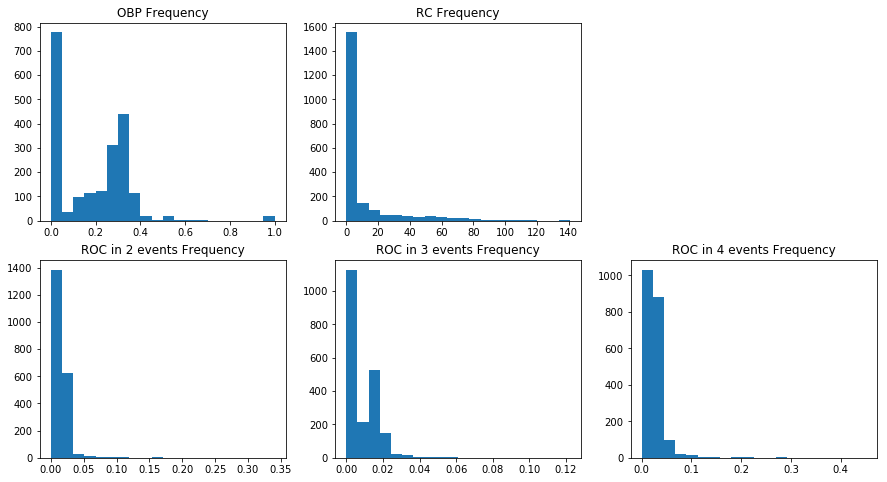

In [67]:
#distribution of OBP, RC, and all ROC scores 
binSize = 20
plt.figure(figsize=(15,8))
plt.subplot(2, 3, 1)
plt.hist(statsDF['OBP'], bins=binSize)
plt.title("OBP Frequency")
plt.subplot(2, 3, 2)
plt.hist(statsDF['RC'], bins=binSize)
plt.title("RC Frequency")
plt.subplot(2, 3, 4)
plt.hist(statsDF['2ROC'], bins=binSize)
plt.title("ROC in 2 events Frequency")
plt.subplot(2, 3, 5)
plt.hist(statsDF['3ROC'], bins=binSize)
plt.title("ROC in 3 events Frequency")
plt.subplot(2, 3, 6)
plt.hist(statsDF['4ROC'], bins=binSize)
plt.title("ROC in 4 events Frequency")
plt.show()

# Correlation 

We can also observe each point of data compared to one another in order to visualize the relationships.

Correlation between 2ROC and 3ROC : 0.379399685564


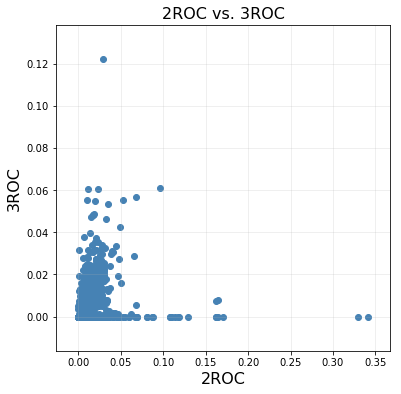

In [73]:
#correlation or ROCs with RC, OBP 
choice1 = '2ROC'
choice2 = '3ROC'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
axes.scatter(statsDF[choice1], statsDF[choice2], color = "steelblue")
axes.grid(alpha=0.25)
axes.set_xlabel(choice1, fontsize=16)
axes.set_ylabel(choice2, fontsize=16)
axes.set_title(choice1+ " vs. " + choice2, fontsize=16)

c = statsDF[choice1].corr(statsDF[choice2], method='pearson')
print("Correlation between", choice1, "and", choice2, ":" ,c)

Full correlation table:

In [112]:
statsDF.drop(['firstName', 'lastName'], axis=1).corr(method='pearson')

,RC,OBP,2ROC,3ROC,4ROC
RC,1.000000,0.444398,0.220340,0.403546,0.189753
OBP,0.444398,1.000000,0.239780,0.424737,0.360810
2ROC,0.220340,0.239780,1.000000,0.379400,0.650344
3ROC,0.403546,0.424737,0.379400,1.000000,0.399572
4ROC,0.189753,0.360810,0.650344,0.399572,1.000000
